In [1]:
import torch
import torchvision.transforms as T
import yaml
from   omegaconf import OmegaConf

from   ldm.util  import instantiate_from_config

# Instantiate model from config YAML file
config_path = "ldm/yaml_config.yaml"
config      = OmegaConf.load(config_path)
model       = instantiate_from_config(config.model)

# Load checkpoint
ckpt_path = "model.ckpt" # Unzip from https://ommer-lab.com/files/latent-diffusion/sr_bsr.zip
sd        = torch.load(ckpt_path, map_location="cpu")["state_dict"]
model.load_state_dict(sd, strict=False)

print(model)

/scratch/coop/drozda/torch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=160, out_features=640, bias=True)
        (1): SiLU()
        (2): Linear(in_features=640, out_features=640, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [2]:
model.eval()

with torch.no_grad():
    # For sampling, you need:
    # - conditioning (low-res image)
    # - batch size
    # - return intermediates (optional)

    conditioning = torch.randn(1, 3, 64, 64)  # Your low-res input

    # # Method 1: Simple sampling
    # samples = model.sample(
    #     cond=conditioning,
    #     batch_size=1,
    #     return_intermediates=False
    # )

    # Method 2: With DDIM sampling (common for inference)
    from ldm.ddim import DDIMSampler

    sampler = DDIMSampler(model)

    # Sample shape: [C, H, W] in latent space
    shape = (3, 64, 64)

    samples_ddim, _ = sampler.sample(
        2,  # number of steps
        1,  # batch_size
        shape,
        conditioning=conditioning
    )
    hr_images = model.decode_first_stage(samples_ddim)    # Decode from latent to pixel space using autoencoder
    print(f"Latent samples shape: {samples_ddim.shape}")  # Should be [1, 3, 64, 64]
    print(f"High-res images shape: {hr_images.shape}")    # Should be [1, 3, 256, 256]

Selected timesteps for ddim sampler: [  1 501]
Selected alphas for ddim sampler: a_t: tensor([0.9970, 0.1491]); a_(t-1): [0.99849999 0.99699563]
For the chosen value of eta, which is 0.0, this results in the following sigma_t schedule for ddim sampler tensor([0., 0.], dtype=torch.float64)
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 2 timesteps


DDIM Sampler: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Latent samples shape: torch.Size([1, 3, 64, 64])
High-res images shape: torch.Size([1, 3, 256, 256])


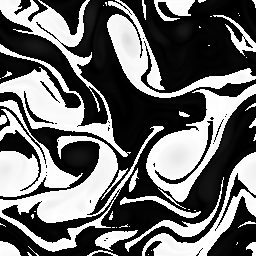

In [11]:
from PIL import Image
import torchvision.transforms as T

image_source = "data/lr_image.png" # From https://user-images.githubusercontent.com/38061659/199705896-b48e17b8-b231-47cd-a270-4ffa5a93fa3e.png
img          = Image.open(image_source).convert('RGB')
img

In [12]:
img.size

(256, 256)

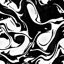

In [19]:
img_low = img.resize((64,64))
img_low.save(f"data/input_image.png")
img_low

In [14]:
preprocess = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),                                           # Convert to tensor [0, 1]
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Map to [-1, 1]
])
lr_image = preprocess(img).unsqueeze(0)                     # Shape becomes [1, 3, H, W]

In [15]:
lr_image.shape

torch.Size([1, 3, 64, 64])

In [16]:
model.eval()

with torch.no_grad():
    # For sampling, you need:
    # - conditioning (low-res image)
    # - batch size
    # - return intermediates (optional)

    # Method 2: With DDIM sampling (common for inference)
    from ldm.ddim import DDIMSampler

    sampler = DDIMSampler(model)

    # Sample shape: [C, H, W] in latent space
    shape = (3, 64, 64)

    samples_ddim, _ = sampler.sample(
        100,  # number of steps
        1,    # batch_size
        shape,
        conditioning=lr_image
    )
    hr_images = model.decode_first_stage(samples_ddim)    # Decode from latent to pixel space using autoencoder
    print(f"Latent samples shape: {samples_ddim.shape}")  # Should be [1, 3,  64,  64]
    print(f"High-res images shape: {hr_images.shape}")    # Should be [1, 3, 256, 256]

Selected timesteps for ddim sampler: [  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531
 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711
 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891
 901 911 921 931 941 951 961 971 981 991]
Selected alphas for ddim sampler: a_t: tensor([9.9700e-01, 9.8171e-01, 9.6600e-01, 9.4988e-01, 9.3337e-01, 9.1647e-01,
        8.9921e-01, 8.8161e-01, 8.6368e-01, 8.4546e-01, 8.2696e-01, 8.0820e-01,
        7.8921e-01, 7.7001e-01, 7.5064e-01, 7.3111e-01, 7.1145e-01, 6.9170e-01,
        6.7188e-01, 6.5201e-01, 6.3213e-01, 6.1227e-01, 5.9245e-01, 5.7270e-01,
        5.5305e-01, 5.3353e-01, 5.1416e-01, 4.9498e-01, 4.7600e-01, 4.5725e-01,
        4.3875e-01, 4.2054e-01, 4.0263e-01, 3.8504e-01, 3.6779e-01, 3.5090e-01,
        3.3439e-01, 3.1828e-01, 3.025

DDIM Sampler: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Latent samples shape: torch.Size([1, 3, 64, 64])
High-res images shape: torch.Size([1, 3, 256, 256])


(1, 256, 256, 3)


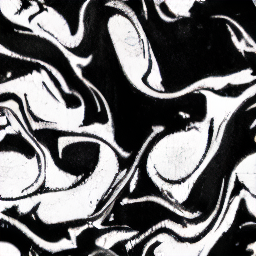

In [18]:
import numpy as np
sample = hr_images.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0])
a.save(f"data/hr_image.png")
a